In [320]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon, minkowski, euclidean, cosine
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pickle as pkl

## CLASS to get the embeddings 

In [446]:
class Get_Embedding(object):
    
    def __init__(self, uri, user, password, database=None):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))
        self._session = self._driver.session() if database is None else self._driver.session(database=database)
        self._tx = None
        
    def close(self):
        self._driver.close()
        
    def get_embeddings(self, prop):
        
        with self._session as session:
            embeddings = session.write_transaction(self._get_embedding, prop)
            
        p = pd.DataFrame(embeddings)
        print("Dumping df into pickle")
        self.safe_pickle(p, prop+"_embeddings")
        return p
    
    def safe_pickle(self, df:pd.DataFrame, name:str ,safe_path:str="Experiments_embeddings_pickles/"):
        try:
            df.to_pickle(safe_path+name+".pkl")
            print("dataframe dumped correctly")
        except:
            print("error dumping dataframe, closing... ")
            self.close()
            sys.exit(1)
        return df
        
    
    @staticmethod
    def _get_embedding(tx, prop):
        
        dataframe = {"src":[], "trg": [], "src_emb": [], "trg_emb":[], "gt":[]}
        result = tx.run(
                "match (n:Individual)-[r:Candidate_Pairs]-(m:Individual) "
                "with n._id as src, m._id as trg, n.{} as emb1, m.{} as emb2, r.class as gt "
                "return src, trg, gt, emb1 , emb2 ".format(prop, prop)
        )
        for registre in result:
            dataframe["src"].append(registre["src"])
            dataframe["trg"].append(registre["trg"])
            dataframe["src_emb"].append(registre["emb1"])
            dataframe["trg_emb"].append(registre["emb2"])
            dataframe["gt"].append(registre["gt"])
            
        return dataframe
    
Emb = Get_Embedding("bolt://localhost:11012", "neo4j", "1234", "tfg")
p = Emb.get_embeddings("Experiment1")

Dumping df into pickle
dataframe dumped correctly


## GMEAN and Youden's J statistic

In [364]:
def J_statistic(y_true:list, y_score:list):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    
        # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    return best_thresh
    

def G_mean(y_true:list, y_score:list):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    return thresholds[ix]

## SIMILARITY FUNCTIONS

In [365]:
def smoothed_sigmoide(x):
    numerator = x - np.mean(x)
    denominator = np.std(x)
    fraction = numerator / denominator

    return 1.0 / (1.0 + np.exp(-fraction))

def Jensen_sim(p:list,q:list, smoothed=False):
    p_x = smoothed_sigmoide(p) if smoothed == True else p
    q_x = smoothed_sigmoide(q) if smoothed == True else q
    return jensenshannon(p_x,q_x)

    
def Minkowski(u,v):
    return minkowski(u,v)



In [366]:
def conver_sim_to_column(df:pd.DataFrame, name_column:str, sim_function):
    df[name_column] = df.apply(lambda x: sim_function(x["src_emb"], x["trg_emb"]), axis=1)

def prepare_df_to_compare(df:pd.DataFrame, function_names:list = [Minkowski, Jensen_sim],num_experiment:int = 5):
    column_name = ["Exp"+str(num_experiment)+i.__name__ for i in function_names ]
    for name, func in zip(column_name, function_names):
        
        conver_sim_to_column(df, name, func)
        
    return df
#p = prepare_df_to_compare(p)
#p = p.fillna(0)

## Metrics

In [97]:
def auc_score(gt, values):
    return roc_auc_score(gt, values)

def conf(gt:list, pred:list):
    return confusion_matrix(gt, pred)

def apply_threshold(df:pd.DataFrame, name_sim:str, name_colum:str, model):
    assert "gt" in df.columns and name_sim in df.columns
    best_thres = get_best_threshold(df["gt"].values, df[name_sim].values, model)
    
    df[name_colum] = df.apply(lambda row: int(row[name_sim] > best_thres), axis=1)
    return df
       

def get_best_threshold(gt:list, similarities:list, model):
    th = model(gt, similarities)
    return th

def euclidean_transform(values:list):
    return 1/(1+ values)
    

def logi(array):
    return 1/(1+(1/math.e**(300*array)))


# COSINE RESULTS OF DIFF EXPERIMENTS

In [448]:
df = pd.read_csv("Experiment3.csv", sep=",")

In [449]:
df

,src,trg,cos,eucl,gt
0,191000010001,191521980461,0.999976,0.993164,0
1,191000010001,191532110682,0.999995,0.996719,1
2,191000010001,191528850615,0.999940,0.989136,0
3,191000010001,191508030161,0.999941,0.989214,0
4,191000010001,191503220068,0.999944,0.989528,0
...,...,...,...,...,...
249773,193063911476,192433190660,0.999955,0.990640,0
249774,193063911476,192430700610,0.999974,0.992835,0
249775,193063911476,192450511001,0.999976,0.993050,0
249776,193063911476,192450491001,1.000000,0.999741,1


Best Threshold=0.999980


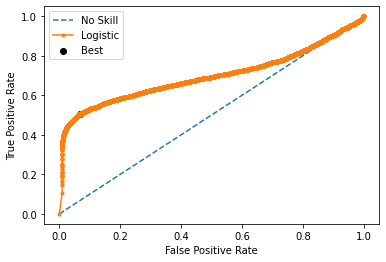

In [450]:
df = apply_threshold(df,"cos", "pred_cos", J_statistic)

# EUCLIDEAN RESULTS

Best Threshold=0.993639


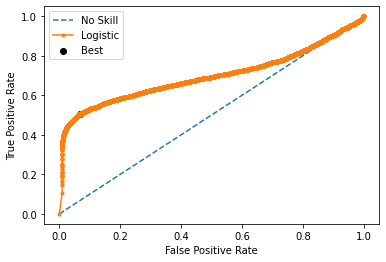

In [453]:
df = apply_threshold(df,"eucl", "pred_euc", J_statistic)

# SHANNON JENSEN AND MINKOWSKI

In [457]:
df5 = pd.read_pickle("Experiments_embeddings_pickles/Experiment3_embeddings.pkl")

In [458]:
df5 = prepare_df_to_compare(df5)
df5 = df5.fillna(0)

In [459]:
df5

,src,trg,src_emb,trg_emb,gt,Exp5Minkowski,Exp5Jensen_sim
0,191000010001,191521980461,"[0.06695859641596831, 0.10330248800546933, 0.0...","[0.06692311695937064, 0.10201294729263234, 0.0...",0,0.006883,0.003126
1,191000010001,191532110682,"[0.06695859641596831, 0.10330248800546933, 0.0...","[0.06730908019375564, 0.10341904188356997, 0.0...",1,0.003292,0.001397
2,191000010001,191528850615,"[0.06695859641596831, 0.10330248800546933, 0.0...","[0.06505079732876776, 0.10263819473437871, 0.0...",0,0.010983,0.004868
3,191000010001,191508030161,"[0.06695859641596831, 0.10330248800546933, 0.0...","[0.0658367030822263, 0.10170934154679492, 0.07...",0,0.010903,0.004786
4,191000010001,191503220068,"[0.06695859641596831, 0.10330248800546933, 0.0...","[0.06562969890822846, 0.10178162030694697, 0.0...",0,0.010583,0.004635
...,...,...,...,...,...,...,...
249773,193063911476,192433190660,"[0.06711666739359026, 0.1012911291806077, 0.07...","[0.06574412463359533, 0.10110653435040172, 0.0...",0,0.009448,0.004111
249774,193063911476,192430700610,"[0.06711666739359026, 0.1012911291806077, 0.07...","[0.06691459361740863, 0.10024674102508183, 0.0...",0,0.007216,0.003231
249775,193063911476,192450511001,"[0.06711666739359026, 0.1012911291806077, 0.07...","[0.06732515022574384, 0.10143853694426005, 0.0...",0,0.006999,0.002942
249776,193063911476,192450491001,"[0.06711666739359026, 0.1012911291806077, 0.07...","[0.0671691366897347, 0.1012804888111666, 0.071...",1,0.000259,0.000113


In [484]:
df5["Exp5Minkowski"] = (euclidean_transform(smoothed_sigmoide(df5["Exp5Minkowski"])))

Best Threshold=0.799997


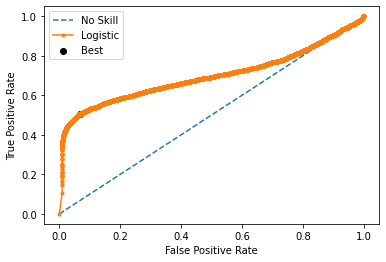

In [491]:
df5 = apply_threshold(df5, "Exp5Minkowski", "pred_min",J_statistic)

# NODE SIMILARITY

In [247]:
df = pd.read_csv("Node_Sim/Node_Sim5.csv", sep=",")

In [248]:
df.columns = ["Person1", "Person2", "similarity", "gt"]

In [249]:
df

,Person1,Person2,similarity,gt
0,191000020001,191532120682,0.294118,1
1,191000020001,191511510241,0.222222,0
2,191000030001,191532130682,0.150000,1
3,191000040001,191532140682,0.150000,1
4,191000180005,191532250685,0.200000,1
...,...,...,...,...
1673,192455401090,193062981458,0.300000,1
1674,192455411090,193062991458,0.300000,1
1675,192455581094,193052401189,0.200000,1
1676,192455601094,193052431189,0.266667,1


Best Threshold=0.258065, G-Mean=0.577


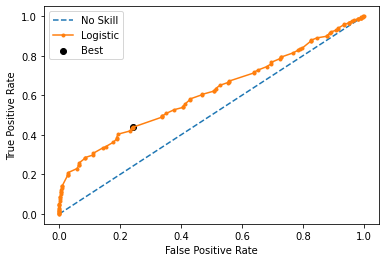

In [256]:
df = apply_threshold(df,"similarity", "pred", G_mean)